In [1]:
import random

import coarse_fine_volatility as cfvol
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch
import train_garch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
# plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
real_data = real_data.loc[:, np.all(~np.isnan(real_data), axis=0)]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")
print(f"Frist Date {real_data.index[0]:%Y-%m-%d}")
print(f"Last Date {real_data.index[-1]:%Y-%m-%d}")

Shape: (9216, 233)
Frist Date 1987-08-05
Last Date 2024-03-01


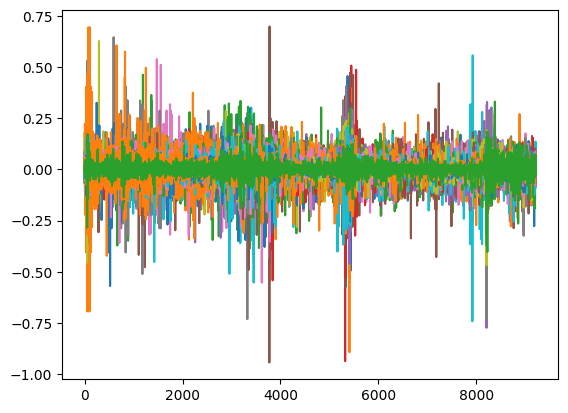

In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data
np_log_price = np.cumsum(np_ret, axis=0)
plt.plot(np_ret)
plt.show()

/home/nico/edu/masterthesis/code/src/stylized_facts/coarse_fine_volatility.py:217: RuntimeWarning: divide by zero encountered in power
  y_lin = -np.exp(alpha) * dll_x ** beta


Real Data coarse fine volatility argmin 4
Real Data coarse fine volatility argmin_std 12.882527429695081
Real Data coarse fine volatility beta -1.3158444829200642
Real Data coarse fine volatility beta_std 0.9285091872521446
Real Data coarse fine volatility corr 0.8089420919805931
Real Data coarse fine volatility corr_std 0.2014347144471731
Real Data coarse fine volatility beta_min -9.389689121969688
Real Data coarse fine volatility beta_max 0.6878266695738646


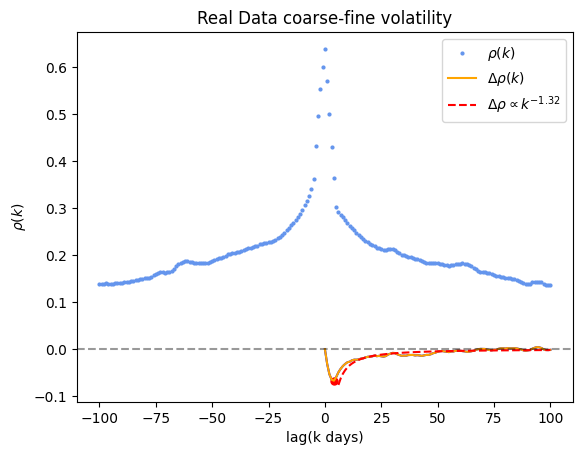

In [7]:
stats = [
    "argmin",
    "argmin_std",
    "beta",
    "beta_std",
    "corr",
    "corr_std",
    "beta_min",
    "beta_max",
]
cfvol.visualize_stat(plt.gca(), np_ret, "Real Data", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/cfv.png")
plt.show()
plt.close()

## Garch Normal, p=3, q=3

In [8]:
cache = "../data/cache/Garch_normal_3_3_2024_06_26-11_11_24"
garch_log_rets = train_garch.sample_garch(cache)

# Drop bad fits
garch_log_rets = garch_log_rets[:, np.sum(np.isnan(garch_log_rets), axis=0) == 0]

/home/nico/edu/masterthesis/code/src/garch/train_garch.py:131: RuntimeWarning: invalid value encountered in log
  log_returns.append(np.log(return_simulation))


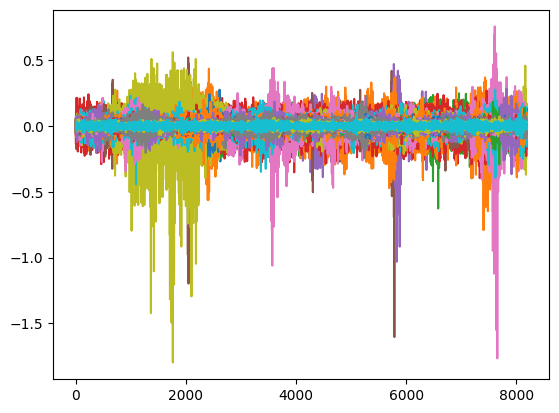

In [9]:
plt.plot(garch_log_rets)
plt.show()

GARCH Normal 3 3 coarse fine volatility argmin 63
GARCH Normal 3 3 coarse fine volatility argmin_std 29.879007747409453
GARCH Normal 3 3 coarse fine volatility beta -0.4559436323813218
GARCH Normal 3 3 coarse fine volatility beta_std nan
GARCH Normal 3 3 coarse fine volatility corr 0.06928351106427572
GARCH Normal 3 3 coarse fine volatility corr_std 0.3011266870109325
GARCH Normal 3 3 coarse fine volatility beta_min nan
GARCH Normal 3 3 coarse fine volatility beta_max nan


/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/nico/.cache/pypoetry/virtualenvs/synthetic-data-5lnic9a9-py3.11/lib/python3.11/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


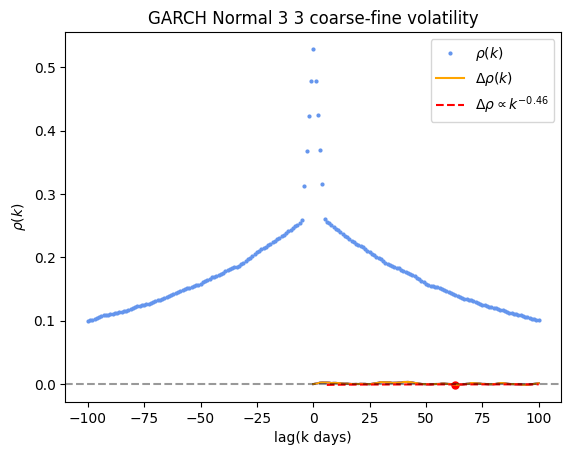

In [10]:
stats = [
    "argmin",
    "argmin_std",
    "beta",
    "beta_std",
    "corr",
    "corr_std",
    "beta_min",
    "beta_max",
]
cfvol.visualize_stat(plt.gca(), garch_log_rets, "GARCH Normal 3 3", stats)
# plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/cfv.png")
plt.show()
plt.close()